In [2]:
import random, copy, os, operator, sys
from joblib import Parallel, delayed

import numpy as np
# from numba import jit
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100
from scipy.spatial import Delaunay
from PointSystem import PointSystem

from perlin_noise import PerlinNoise

In [2]:
def evalObject(object, f: callable) -> tuple[any, float]:
    e = object.evaluate(f)
    # res = e if e < 1 else (1 / object.M**2) / sys.float_info.epsilon
    # res = e * 1 / np.power(object.M)
    # res = e if e < 1 else 1 + np.sqrt(np.log10(np.log10((1 / object.M**2) / sys.float_info.epsilon)))
    # res = e if e < 1 else np.log10((1 / object.M**2) / sys.float_info.epsilon)
    # res = e if e < 1 else 1 + 1 / object.M
    res = e
    return (object, res)

def evalObjectList(objectList: list[any], f: callable) -> list[tuple[any, float]]:
    return Parallel(n_jobs=os.cpu_count())(delayed(evalObject)(object, f) for object in objectList)

def mutateXevalObject(object, f: callable) -> tuple[any, float]:
    object.Mutate(f)
    return evalObject(object, f)

def mutateXevalObjectList(objectList: list[any], f: callable) -> list[tuple[any, float]]:
    return Parallel(n_jobs=os.cpu_count())(delayed(mutateXevalObject)(object, f) for object in objectList)

def generatePopulation(objectGenerator: callable, population_size: int = 100) -> list:
    return [objectGenerator() for _ in range(population_size)]

# @jit
def training(f: callable, population: list, epochs: int = 100):
    
    population_size = len(population)
    # генерируем популяцию
    objects = evalObjectList(population, f)
    objects.sort(key=lambda d: d[1], reverse=False)
    evaluations = [d[1] for d in objects]
    plt.plot(evaluations, color='black', label='#')

    bestList = list()

    # "обучаем"
    for epoch in range(epochs):
        
        _objects: list[PointSystem] = list()
        
        while len(_objects) < population_size:
            i = random.choice(range(population_size))
            # prob = np.exp(-np.pi*(i/population_size)+1)
            # prob = 1/(np.pi*np.pi*np.pi*(i/population_size+0.001))
            # prob = -np.log(i/population_size)
            x = i / population_size
            prob = np.exp(-(np.pi*x)**2)#+np.power(10, x)
            if random.random() < prob:
                _objects.append(copy.deepcopy(objects[i][0]))
        
        objects = mutateXevalObjectList(_objects, f)
        # objects.sort(key=lambda d: d[1], reverse=True)
        objects.sort(key = operator.itemgetter(1), reverse=False)
        evaluations = [d[1] for d in objects]
        if i % 10 == 0: plt.plot(evaluations, label=f'#{epoch}')
        bestList.append(objects[0])
        # if evaluations[0] >= 1:
        #     break
    
    print(f'лучший результат: {evaluations[0]}')
    # plt.legend()
    plt.show()
    
    return [d[0] for d in objects], bestList

In [13]:
N = 2       # размерность системы
M = 10    # число точек

noise_generator = PerlinNoise(octaves=2, seed=1)
# ng = lambda point: noise_generator(point) * 3 + 2
# ng = lambda point: noise_generator(point) * 10 + 6
# ng = lambda point: 0.5
# ng = lambda point: np.exp((-np.linalg.norm(point-0.5)) / (0.5/3)**2) * 100
ng = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/3)**2) * 100

In [12]:
p = np.array([0.3,0.4])
np.power(np.linalg.norm(p-0.5), 2)

0.049999999999999996

In [4]:
p = np.array([0.7,0.8])
p, ng(p), np.linalg.norm(p)

(array([0.7, 0.8]), 23.640224185438104, 1.063014581273465)

In [5]:
PointSystem.grad(ng, p, 0.001)

array([-52.45287346, -78.67940143])

лучший результат: 5.111866005035033


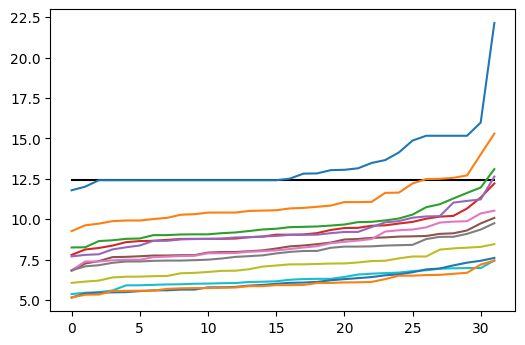

In [14]:
# res, bestList = training(ng, generatePopulation(lambda: PointSystem(10, N), 16), 100)
res, bestList = training(ng, generatePopulation(lambda: PointSystem(81, 2, True), 32), 100)

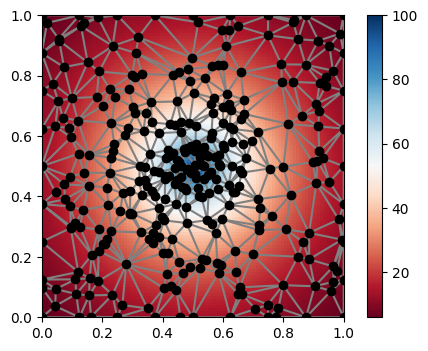

(None,
 5.111866005035033,
 0.24113946820395865,
 327,
 1255,
 array([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]))

In [15]:
n, m = 100, 100
# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = np.array([[ng(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])
extent = [0, 1, 0, 1]
im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')
plt.colorbar(im)
# ps = PointSystem(256**4, 2, True)
ps = res[0]
# ps = PointSystem(49, 2, True)
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
plt.plot(points[:,0], points[:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(), ps.evaluate(ng), ps.characteristic_distance, ps.M, len(ps.edges), ps.boundary_points

лучший результат: 1.0357142857142858


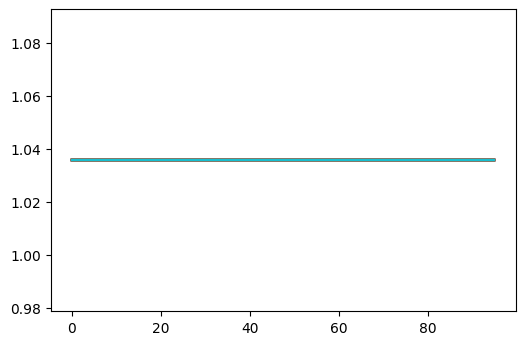

In [15]:
res, bestList = training(ng, generatePopulation(lambda: copy.deepcopy(res[0]), 96), 100)

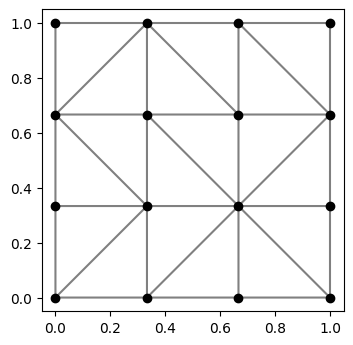

(None, 1.0, 0.9663495064760467, 16, 41)

In [6]:
ps = PointSystem(16, 2, True)
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
plt.plot(points[:,0], points[:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(), ps.evaluate(ng), ps.characteristic_distance, ps.M, len(ps.edges)

In [13]:
len(bestList)

100

In [10]:
import matplotlib
from matplotlib import pyplot as plt
from celluloid import Camera

n, m = 100, 100
# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = np.array([[ng(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])
extent = [0, 1, 0, 1]
fig = plt.figure(dpi = 300)
im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')

plt.gca().set_aspect('equal', adjustable='box')

camera = Camera(fig)
for i, ps in enumerate(bestList[:]):
    tri = ps[0].triangulation
    points = ps[0].points
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
    t = plt.plot(points[:,0], points[:,1], 'o', color='black')
    im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')
    # plt.colorbar(im)
    plt.legend(t, [f'#{i}'], loc='upper center', bbox_to_anchor=(0.5, -0.05))
    camera.snap()

animation = camera.animate()
animation.save('evolution_animation.gif', writer = 'imagemagick')

ModuleNotFoundError: No module named 'celluloid'

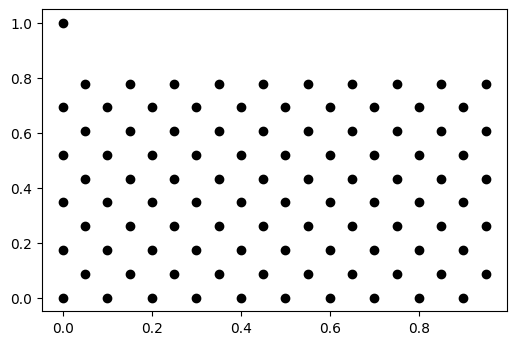

In [6]:
# arr = np.zeros((M, M))
h = 1/M
points = list()
for n in range(M):
    for m in range(M):
        if m % 2 == 0:
            point = [h*n, np.sqrt(3)/2*h*m]
        else:
            point = [h*(n+0.5), np.sqrt(3)/2*h*m]
        points.append(point)
points.append([0, 1])
# points.append([1, 0])
points = np.array(points)
plt.plot(points[:,0], points[:,1], 'o', color='black')

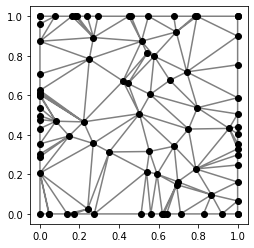

In [46]:
ps = res[0]
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
plt.plot(points[:,0], points[:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [7]:
[evalObject(r, ng)[1] for r in res]

[2.0067884805786176,
 2.0065941964407807,
 2.0065941964407807,
 2.0064401004815373,
 2.0063634897391998,
 2.0063252926550037,
 2.0061732195295265,
 2.0061353786322655,
 2.005984716195238,
 0.9991928974979822]

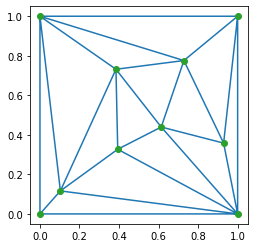

(None, 0.23333333333333334)

In [26]:
ps = PointSystem(M, N)
# x, y = points.T
# plt.scatter(x,y)
# plt.show()
tri = ps.triangulation
points = ps.points
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.show(), ps.evaluate(ng)

In [14]:
import plotly.graph_objects as go
n, m = 100, 100

# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = np.array([[ng(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])

fig = go.Figure(data=[
    go.Surface(z=noise)
    ])
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [58]:
fig

In [19]:
np.gradient(ng)

[]

In [26]:
# @jit
def training(M: int, N: int, population_size: int = 100, epochs: int = 100):
    
    # генерируем популяцию
    PSs: list[PointSystem] = list()
    Es: list[float] = list()
    for _ in range(population_size):
        ps = PointSystem(M, N)
        e = ps.evaluate(ng)
        PSs.append((ps, e))
        Es.append(e)
    PSs.sort(key=lambda d: d[1], reverse=True)
    Es.sort(reverse=True)
    plt.plot(Es, color='black', label='#')

    # "обучаем"
    for epoch in range(epochs):
        newPSs: list[PointSystem] = list()
        newEs: list[float] = list()
        while len(newPSs) < population_size:
            i = random.choice(range(population_size))
            # prob = np.exp(-np.pi*(i/population_size)+1)
            # prob = 1/(np.pi*np.pi*np.pi*(i/population_size+0.001))
            # prob = -np.log(i/population_size)
            prob = np.exp(-(np.pi*i)**2/population_size**2)
            if random.random() < prob:
                newPS = copy.deepcopy(PSs[i][0])
                newPS.Mutate()
                e = newPS.evaluate(ng)
                newPSs.append((newPS, e))
                newEs.append(e)
        newPSs.sort(key=lambda d: d[1], reverse=True)
        newEs.sort(reverse=True)
        plt.plot(newEs, label=f'#{epoch}')
        PSs = newPSs
        Es = newEs
    
    print(f'лучший результат: {Es[0]}')
    plt.legend()
    plt.show()

In [ ]:
training(M, N, 100, 10)